## **16.XGBoost Code 실습**

[목적]
  - GBM Model을 획기적인 System Design을 활용하여 개선한 XGBoost Model 실습 및 해석
  - XGBoost의 경우 Missing Value를 Model 자체 내에서 처리해주기 때문에 삭제하지 않아도 됨
  - Big Data를 빠르게 학습함

[Process]
  1. Define X's & Y
  2. Split Train & Valid dataset
  3. Modeling
  4. Model 해석

먼저, **XGBoost (eXtreme Gradient Boosting)**는 Gradient Boosting Machines (GBM)를 기반으로 하면서도 보다 최적화되고 확장된 버전입니다. XGBoost는 그 구현이 효율적이라 대용량 데이터셋에도 빠른 학습 속도를 보이며, 누락된 데이터를 처리할 수 있는 능력과 정규화 등의 기능을 통해 모델의 성능도 우수합니다.

- 획기적인 System Design:

 - 병렬 처리: XGBoost는 트리의 구성 요소별로 병렬 처리를 지원하여 학습 시간을 크게 단축시킵니다.
 - 규제화: GBM에는 규제화 기능이 포함되어 있지 않지만, XGBoost는 L1 (Lasso Regression)과 L2 (Ridge Regression) 규제화를 제공하여 모델의 과적합을 방지합니다.
 - 가지치기 (Pruning): XGBoost는 깊이가 max_depth로 제한된 트리를 먼저 성장시킨 후, 가지치기를 통해 불필요한 노드를 제거합니다. 이 방식은 과적합을 방지하고 더 간결한 모델을 생성합니다.
- Missing Value 처리:

 - 전통적인 GBM은 결측치 처리에 대한 특별한 기능을 제공하지 않습니다. 따라서 사전에 결측치를 채우거나 제거하는 전처리가 필요합니다.
 - XGBoost는 학습 시 결측치를 자동으로 처리합니다. 트리를 분할할 때, 결측치가 있는 피쳐에 대해 좌측 노드와 우측 노드로 어떤 것이 더 좋은지를 학습하게 됩니다. 따라서 결측치 처리를 위한 별도의 전처리 과정이 필요하지 않습니다.
- Big Data 학습:

 - XGBoost는 효율적인 메모리 사용과 데이터 구조를 활용하여 대용량 데이터를 빠르게 학습할 수 있습니다.
 - 또한, 분산형 컴퓨팅 환경에서도 사용될 수 있어, 빅 데이터 환경에서의 학습도 지원합니다.

In [1]:
import os
import gc
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier, XGBRegressor
from collections import Counter

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


[Data Condition Check]

XGBoost Package의 경우 변수 Name 중 특수 문자가 들어가면 오류가 나게 되어 있음
따라서 변수이름들을 모두 전처리 해줘야함

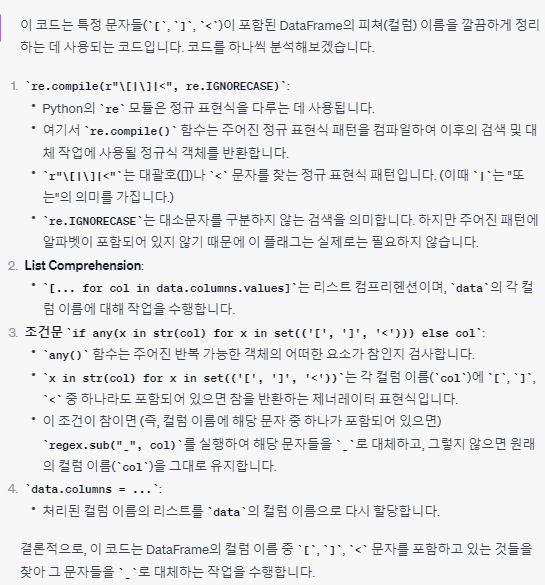

In [4]:
# Feature Name Cleaning
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [6]:
# cleaned_columns = []

# for col in data.columns.values:
#     # 컬럼 이름에 '[', ']', 또는 '<' 가 포함되어 있는지 검사
#     contains_special_char = any(x in str(col) for x in set(('[', ']', '<')))

#     if contains_special_char:
#         # 특수 문자가 있다면, 해당 문자를 "_"로 바꾸기
#         new_col_name = regex.sub("_", col)
#         cleaned_columns.append(new_col_name)
#     else:
#         # 특수 문자가 없다면, 원래의 컬럼 이름을 사용
#         cleaned_columns.append(col)


In [7]:
tmp = [1, 1, 1]
set(tmp)

{1}

In [8]:
# Data Quality Checking
col = []
missing = []
level = []
for name in data.columns:

    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna() # 결측치를 모두 제거함
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']),
                     pd.DataFrame(missing, columns=['Missing Percentage']),
                     pd.DataFrame(level, columns=['Level'])], axis=1)

drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)] # 여기에 1은 컬럼이 같은것으로 되어 있는 것을 뜻함
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (532, 22)


- 변수 초기화:

 - col, missing, level: 각 컬럼의 이름, 결측치 비율, 고유값의 수를 저장할 빈 리스트들입니다.
- 각 컬럼에 대한 루프 실행:

  - for name in data.columns: data의 모든 컬럼에 대해 루프를 실행합니다.
- 결측치의 비율 계산:

 - data[name].isnull().sum(): 컬럼 name에 있는 결측치의 수를 계산합니다.
  - missper = ... / data.shape[0]: 결측치의 비율을 계산합니다 (data.shape[0]는 데이터의 행 수를 나타냅니다).
  - missing.append(round(missper, 4)): 결측치의 비율을 소수점 네 번째 자리까지 반올림하여 missing 리스트에 추가합니다.
- 고유값의 수(레벨) 계산:

  - lel = data[name].dropna(): 결측치를 제거합니다.
  - level.append(len(list(set(lel)))): 결측치가 제거된 데이터에서 고유값의 수를 계산하여 level 리스트에 추가합니다.
- 컬럼 이름 저장:

  - col.append(name): 현재 컬럼의 이름을 col 리스트에 추가합니다.
- 정리된 데이터 생성:

  - pd.concat(...): col, missing, level 리스트를 하나의 데이터프레임으로 합칩니다. 이 결과는 summary에 저장됩니다.
- 데이터 품질 기준에 따라 컬럼 제거:

  - drop_col = ...: Level이 1 이하 (즉, 모든 값이 같거나 결측치만 있는 경우) 또는 Missing Percentage가 0.8 (80%) 이상인 컬럼들의 이름을 선택합니다.
  - data.drop(columns=drop_col, inplace=True): 해당 컬럼들을 data에서 제거합니다.
- 결과 출력:

  - print(">>>> Data Shape : {}".format(data.shape)): 처리 후의 data의 형태(행과 열의 수)를 출력합니다.
  
요약하자면, 이 코드는 데이터의 각 컬럼에 대한 결측치 비율과 고유값의 수를 확인하고, 그 결과를 바탕으로 일정 기준을 충족하지 않는 컬럼들을 제거하는 작업을 수행합니다.

In [9]:
drop_col

10    zprior
Name: name, dtype: object

In [10]:
summary

,name,Missing Percentage,Level
0,censor,0.0,2
1,event,0.0,358
2,age,0.0,52
3,wtkg,0.0,312
4,hemo,0.0,2
5,homo,0.0,2
6,drugs,0.0,2
7,karnof,0.0,4
8,oprior,0.0,2
9,z30,0.0,2


In [11]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [12]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 241, 1: 131})
>>>> # of valid data Y : Counter({0: 110, 1: 50})


[XGBoost Parameters]
  - Package : https://xgboost.readthedocs.io/en/stable/
  - booster : Iteration 마다의 Model Run Type을 고를수 있음 (2가지)
    - gbtree : tree-based models
    - gblinear : linear models
  - silent : 학습하면서 running message를 프린트해줌 (Parameter 실험 시 안좋음)
    - 0은 프린트 안해주고, 1은 프린트해줌
  - nthread : 병렬처리 할때 core를 몇개 잡을 것인지
    - default로 잡을 수 있는 모든 core를 잡을 수 있도록 해줌
  - learning_rate : GBM에서 shrinking 하는 것과 같은 것
  - reg_lambda : L2 regularization term on weights (analogous to Ridge regression)
  - reg_alpha : L1 regularization term on weight (analogous to Lasso regression)
  - objective [default=reg:linear]
     - This defines the loss function to be minimized. Mostly used values are:
         - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
         - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
         - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
  - eval_metric [ default according to objective ]
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
        -    rmse – root mean square error
        -    mae – mean absolute error
        -    logloss – negative log-likelihood
        -    error – Binary classification error rate (0.5 threshold)
        -    merror – Multiclass classification error rate
        -    mlogloss – Multiclass logloss
        -    auc: Area under the curve

[XGBoost 매개변수]
   - 패키지 : https://xgboost.readthedocs.io/en/stable/
   - 부스터 : Iteration마다의 Model Run Type을 고를 수 있음(2가지)
     - gbtree : 트리 기반 모델
     - gblinear : 선형 모델
   - Silent : 학습하면서 실행 중인 메시지를 프린트해줌(Parameter 실험 시 알림음)
     - 0은 프린트 안하고, 1은 프린트해줌
   - nthread : 축소 처리할 때 코어를 몇개 잡아서 처리하세요.
     - 기본으로 잡을 수 있는 모든 코어를 잡을 수 있도록 해줌
   - learning_rate : GBM에서 수축하는 것과 같은 것
   - reg_lambda : 가중치에 대한 L2 정규화 항(Ridge 회귀와 유사)
   - reg_alpha : 가중치에 대한 L1 정규화 항(Lasso 회귀와 유사)
   - 목표 [기본값=reg:선형]
      - 최소화할 손실함수를 정의합니다. 주로 사용되는 값은 다음과 같습니다.
          - 이진:로지스틱 – 이진 분류를 위한 로지스틱 회귀, 예측 확률 반환(클래스 아님)
          - multi:softmax – 소프트맥스 목표를 사용한 다중 클래스 분류, 예측 클래스 반환(확률 아님)
또한 고유 클래스 수를 정의하는 추가 num_class(클래스 수) 매개변수를 설정해야 합니다.
          - multi:softprob – Softmax와 동일하지만 각 클래스에 속하는 각 데이터 포인트의 예측 확률을 반환합니다.
   - eval_metric [ 목표에 따른 기본값 ]
     - 검증 데이터에 사용할 측정항목입니다.
     - 기본값은 회귀의 경우 rmse, 분류의 경우 오류입니다.
     - 일반적인 값은 다음과 같습니다.
         - rmse - 제곱평균제곱근 오류
         - mae – 절대 오류를 의미
         - 로그 손실 – 음의 로그 우도
         - 오류 – 이진 분류 오류율(0.5 임계값)
         - merror – 다중클래스 분류 오류율
         - mlogloss – 멀티클래스 로그로스
         - auc: 곡선 아래 면적

[XGBoost]

  - Hyperparameter tuning
  - n_estimators, learning_rate, max_depth, reg_alpha
  - XGBoost은 Hyperparam이 굉장히 많은 알고리즘 중에 하나임
  - 위에 4가지만 잘 조정해도 좋은 결과를 얻을 수 있음

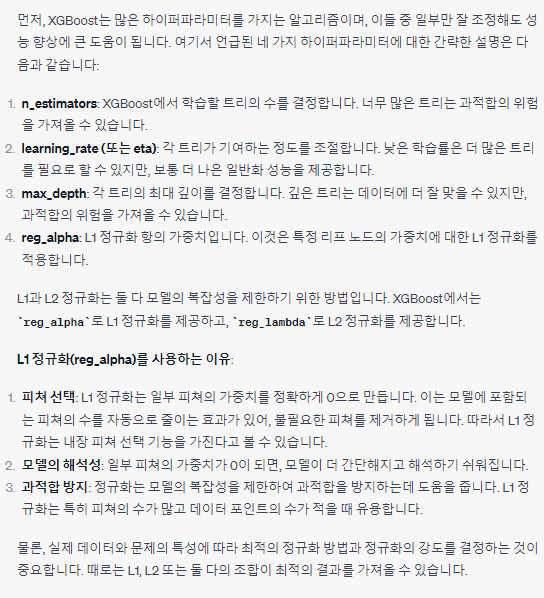

In [13]:
# n_estimators
n_tree = [5, 10, 20]
# learning_rate
l_rate = [0.1, 0.3]
# max_depth
m_depth = [3, 5]
# reg_alpha
L1_norm = [0.1, 0.3, 0.5]

# Modeling
save_n = []
save_l = []
save_m = []
save_L1 = []
f1_score_ = []

cnt = 0

for n in n_tree:
    for l in l_rate:
        for m in m_depth:
            for L1 in L1_norm:

                print(">>> {} <<<".format(cnt))
                cnt +=1
                print("n_estimators : {}, learning_rate : {}, max_depth : {}, reg_alpha : {}".format(n, l, m, L1))
                model = XGBClassifier(n_estimators=n, learning_rate=l,
                                      max_depth=m, reg_alpha=L1, objective='binary:logistic', random_state=119)
                model.fit(X.iloc[train_idx], Y.iloc[train_idx])


                # Train Acc
                y_pre_train = model.predict(X.iloc[train_idx])
                cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
                print("Train Confusion Matrix")
                print(cm_train)
                print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
                print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

                # Test Acc
                y_pre_test = model.predict(X.iloc[valid_idx])
                cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
                print("Test Confusion Matrix")
                print(cm_test)
                print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
                print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
                print("-----------------------------------------------------------------------")
                print("-----------------------------------------------------------------------")
                save_n.append(n)
                save_l.append(l)
                save_m.append(m)
                save_L1.append(L1)
                f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

                # Model 저장
                #import joblib
                #joblib.dump(model, './XGBoost_model/Result_{}_{}_{}_{}_{}.pkl'.format(n, l, m, L1, round(f1_score_[-1], 4)))
                #gc.collect()

>>> 0 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.1
Train Confusion Matrix
[[230  11]
 [ 29 102]]
Train Acc : 0.8924731182795699
Train F1-Score : 0.8360655737704918
Test Confusion Matrix
[[97 13]
 [ 2 48]]
TesT Acc : 0.90625
Test F1-Score : 0.8648648648648649
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.3
Train Confusion Matrix
[[230  11]
 [ 30 101]]
Train Acc : 0.8897849462365591
Train F1-Score : 0.831275720164609
Test Confusion Matrix
[[97 13]
 [ 2 48]]
TesT Acc : 0.90625
Test F1-Score : 0.8648648648648649
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
n_estimators : 5, learning_rate : 0.1, max_depth : 3, reg_alpha : 0.5
Train Confusion Matrix
[[230  11]
 [ 31 100]]
Train Acc :

In [14]:
print(">>> {} <<<\nBest Test f1-score : {}\nBest n_estimators : {}\nBest Learning Rate : {}\nBest Max_depth : {}\nBest L1-norm : {}".format(np.argmax(f1_score_),
                                                                                                                                            f1_score_[np.argmax(f1_score_)],
                                                                                                                                            save_n[np.argmax(f1_score_)],
                                                                                                                                            save_l[np.argmax(f1_score_)],
                                                                                                                                            save_m[np.argmax(f1_score_)],
                                                                                                                                            save_L1[np.argmax(f1_score_)]))

>>> 0 <<<
Best Test f1-score : 0.8648648648648649
Best n_estimators : 5
Best Learning Rate : 0.1
Best Max_depth : 3
Best L1-norm : 0.1


In [15]:
best_model = XGBClassifier(n_estimators=save_n[np.argmax(f1_score_)], learning_rate=save_l[np.argmax(f1_score_)],
                           max_depth=save_m[np.argmax(f1_score_)], reg_alpha=save_L1[np.argmax(f1_score_)], objective='binary:logistic',
                           random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[230  11]
 [ 29 102]]
Train Acc : 0.8924731182795699
Train F1-Score : 0.8360655737704918
Test Confusion Matrix
[[97 13]
 [ 2 48]]
TesT Acc : 0.90625
Test F1-Score : 0.8648648648648649


In [16]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.551445    event
1   0.146731    cd496
2   0.084446    cd420
3   0.084073  preanti
4   0.029171      age
5   0.028750     cd80
6   0.027590      z30
7   0.023935     wtkg
8   0.012641   karnof
9   0.011218     cd40
10  0.000000  symptom
11  0.000000    strat
12  0.000000     str2
13  0.000000     race
14  0.000000        r
15  0.000000   oprior
16  0.000000     homo
17  0.000000     hemo
18  0.000000   gender
19  0.000000    drugs
20  0.000000    cd820


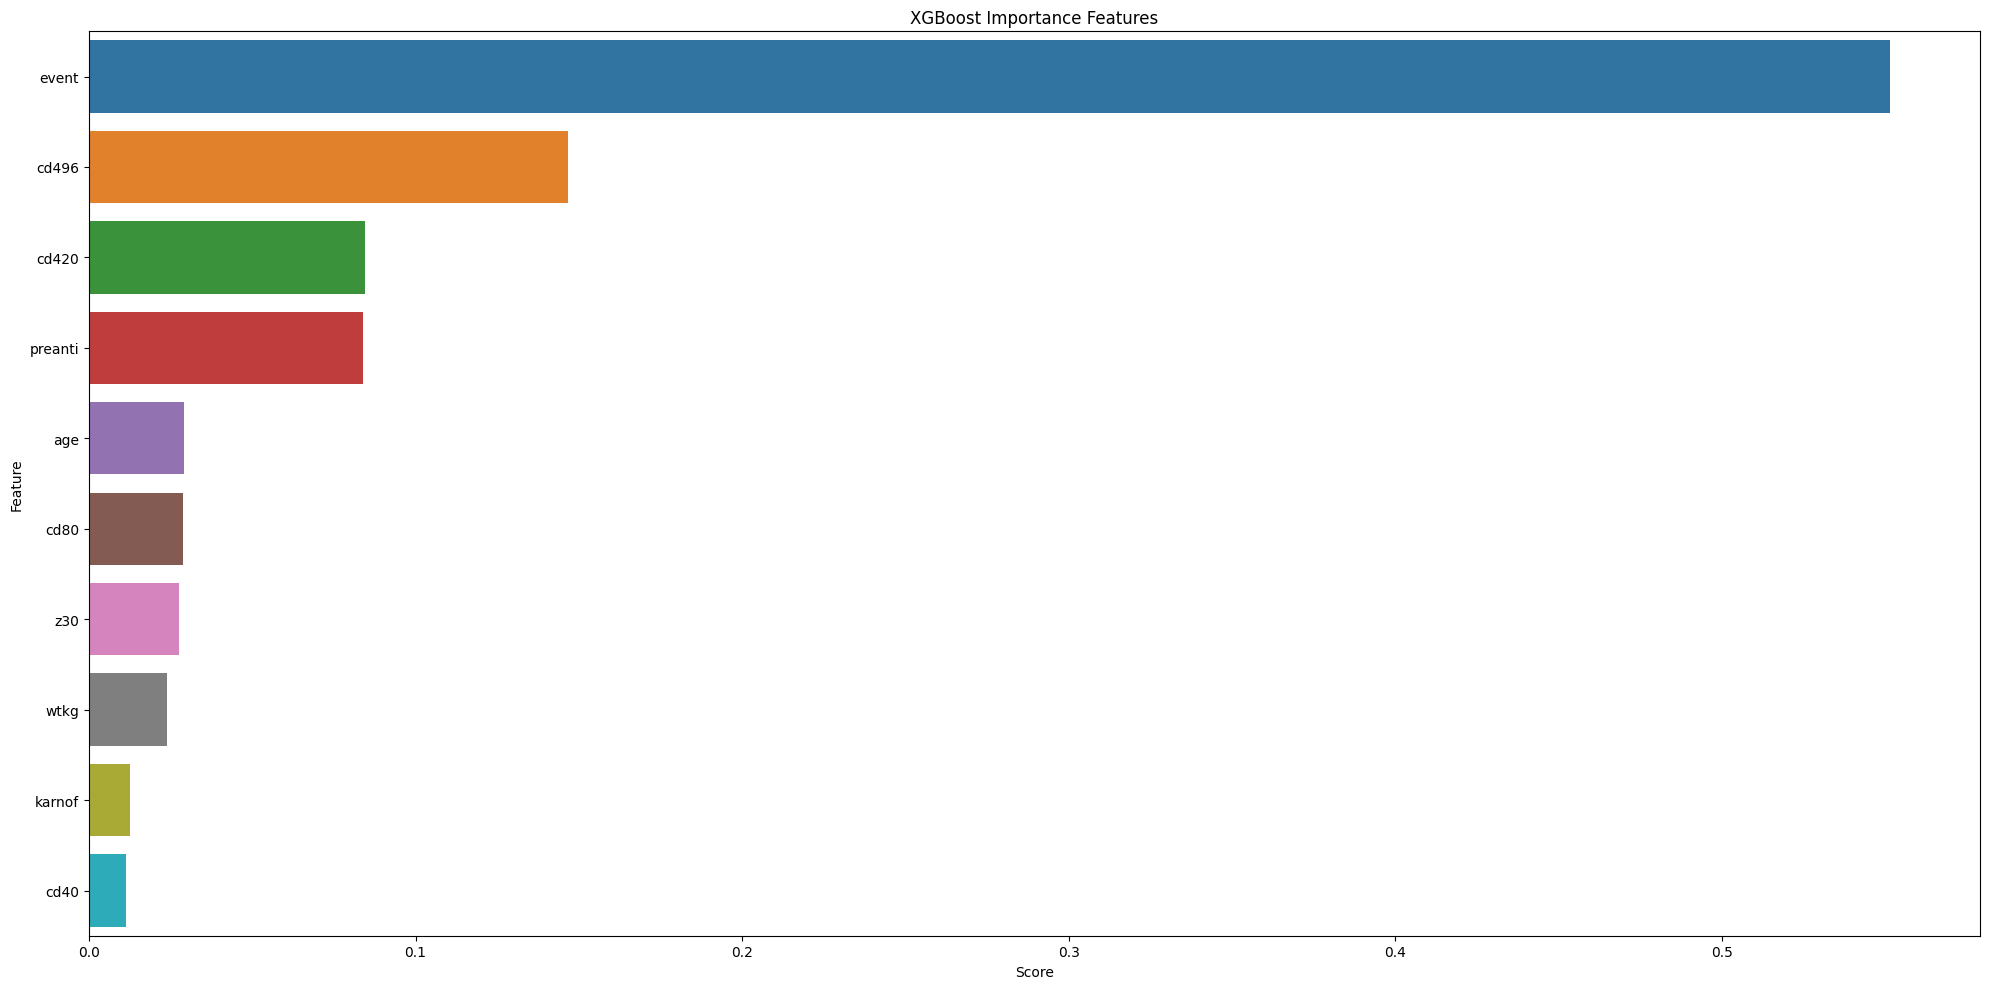

In [17]:
# Importance Score Top 10
feature_map_10 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_10.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('XGBoost Importance Features')
plt.tight_layout()
plt.show()